# Taxi tip prediction with Decision Tree

In the following notebook, we will use the Decision Tree regression model on a real-world dataset collected and provided to the NYC Taxi and Limousine Commission (TLC) by authorized technology providers, with the goal of predicting the amount of tip paid by customers.

## Introduction
The dataset used is avaialable here: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page and corresponds to the TLC (Taxi & Limousine Commission) Yellow Taxi Trip Records of June, 2019.   
The prediction of the tip amount can be modeled as a regression problem based on a set of independent variables

In [1]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv

--2023-10-26 01:02:24--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 364904448 (348M) [text/csv]
Saving to: ‘yellow_tripdata_2019-06.csv’

yellow_tripdata_201 100%[===================>] 348.00M  30.0MB/s    in 11s     

2023-10-26 01:02:38 (30.4 MB/s) - ‘yellow_tripdata_2019-06.csv’ saved [364904448/364904448]



## Import libraries

In [1]:
!pip install --upgrade scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error, r2_score
import time
import warnings
import gc
from sklearn.tree import DecisionTreeRegressor
import sklearn.tree as tree
warnings.filterwarnings('ignore')

## Data Analysys

In this section we will read the dataset into a dataframe and visualize its content and some data statistics.

In [2]:
raw_data = pd.read_csv('yellow_tripdata_2019-06.csv')
print("There are " + str(len(raw_data)) + " observations in the dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")

raw_data.head()

There are 3936004 observations in the dataset.
There are 18 variables in the dataset.


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.0,1.0,N,145.0,145.0,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1.0,0.0,1.0,N,262.0,263.0,2.0,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1.0,4.4,1.0,N,74.0,7.0,2.0,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0.0,0.8,1.0,N,145.0,145.0,2.0,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.7,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


Each row in the dataset represents a taxi trip. As shown above, each row has 18 variables, where the variable called <code>tip_amount</code> represents our target. The goal is to train a model that uses the other variables to predict the value of the tip_amount field

Let's first clean the dataset and retrieve basic statistics about the target variable.

There are 2712719 observations in the dataset.
There are 17 variables in the dataset.


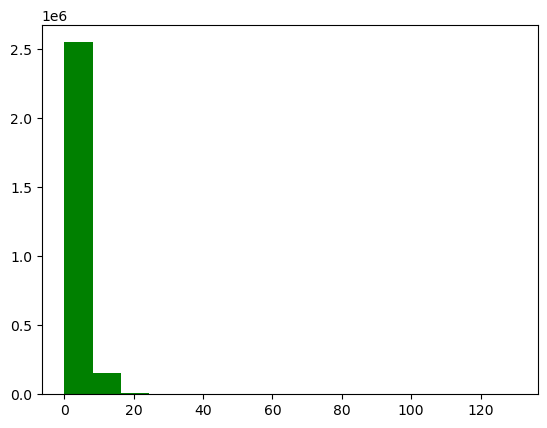

Minimum amount value is  0.01
Maximum amount value is  130.0
90% of the trips have a tip amount less or equal than  5.95


In [3]:
# We drop rows that report 0 tip, it is assumed that these tips were paid in cash
raw_data = raw_data[raw_data['tip_amount'] > 0]

# We also remove outliers, namely those where the tip was larger than the fare cost
raw_data = raw_data[(raw_data['tip_amount'] <= raw_data['fare_amount'])]

# We remove trips with very large fare cost
raw_data = raw_data[((raw_data['fare_amount'] >=2) & (raw_data['fare_amount'] < 200))]

# We will drop the variable total_amount since it contains our target variable
clean_data = raw_data.drop(['total_amount'], axis=1)

del raw_data
gc.collect()

print("There are " + str(len(clean_data)) + " observations in the dataset.")
print("There are " + str(len(clean_data.columns)) + " variables in the dataset.")

plt.hist(clean_data.tip_amount.values, 16, histtype='bar', facecolor='g')
plt.show()

print("Minimum amount value is ", np.min(clean_data.tip_amount.values))
print("Maximum amount value is ", np.max(clean_data.tip_amount.values))
print("90% of the trips have a tip amount less or equal than ", np.percentile(clean_data.tip_amount.values, 90))

We will reduce the data to the first 200.000 records, to avoid out-of-memory issues. Ideally, we would use the complete dataset.

In [4]:
clean_data = clean_data.head(200000)
clean_data.shape

(200000, 17)

## Data preprocessing

In this section we will manipulate the data to make it ready for training.

In [5]:
clean_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.70,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,2.5
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2.0,1.60,1.0,N,79.0,125.0,1.0,9.5,3.0,0.5,1.00,0.0,0.3,2.5
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2.0,1.20,1.0,N,79.0,249.0,1.0,7.5,3.0,0.5,1.00,0.0,0.3,2.5
9,1,2019-06-01 00:29:12,2019-06-01 01:03:13,1.0,8.60,1.0,N,186.0,243.0,1.0,31.5,3.0,0.5,7.05,0.0,0.3,2.5
10,2,2019-06-01 00:01:48,2019-06-01 00:16:06,1.0,1.74,1.0,N,107.0,148.0,1.0,11.0,0.5,0.5,2.96,0.0,0.3,2.5


As we can see above, the dataset contains information such as dates/times, locations, etc. We need to transform the data into a format that is properly handled by our model; for instance, we need to encode categorical features

In [6]:
clean_data['tpep_dropoff_datetime'] = pd.to_datetime(clean_data['tpep_dropoff_datetime'])
clean_data['tpep_pickup_datetime'] = pd.to_datetime(clean_data['tpep_pickup_datetime'])

# Extract pickup and dropoff hour
clean_data['pickup_hour'] = clean_data['tpep_pickup_datetime'].dt.hour
clean_data['dropoff_hour'] = clean_data['tpep_dropoff_datetime'].dt.hour

# Extract pickup and dropoff day of week
clean_data['pickup_day'] = clean_data['tpep_pickup_datetime'].dt.weekday
clean_data['dropoff_day'] = clean_data['tpep_dropoff_datetime'].dt.weekday

# Compute trip time in minutes
clean_data['trip_time'] = (clean_data['tpep_dropoff_datetime'] - clean_data['tpep_pickup_datetime']).astype('timedelta64[m]')

In [7]:
# Drop pickup and dropoff datetimes
clean_data = clean_data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

# Encode categorical features using one-hot encoding
get_dummy_col = ["VendorID","RatecodeID","store_and_fwd_flag","PULocationID", "DOLocationID","payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
proc_data = pd.get_dummies(clean_data, columns = get_dummy_col)

del clean_data
gc.collect()

3811

In the following step we will split our data into a feature matrix and a target vector. Then the feature matrix is normalized using "l1" normalization

In [8]:
y = proc_data[['tip_amount']].values.astype('float32')
proc_data = proc_data.drop(['tip_amount'], axis=1)

X = proc_data.values
X = normalize(X, axis=1, norm='l1', copy=False)

print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (200000, 517) y.shape= (200000, 1)


## Building the model

Lets divided the processed data into subsets for training and testing

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (140000, 517) Y_train.shape= (140000, 1)
X_test.shape= (60000, 517) Y_test.shape= (60000, 1)


In [10]:
regTree = DecisionTreeRegressor(max_depth=8, random_state=35)

t0 = time.time()
regTree.fit(X_train, y_train)
elapsed = time.time()-t0
print("Training time (s):  {0:.5f}".format(elapsed))

Training time (s):  7.27161


## Evaluating the model

Lets start by visualizing the resulting model 

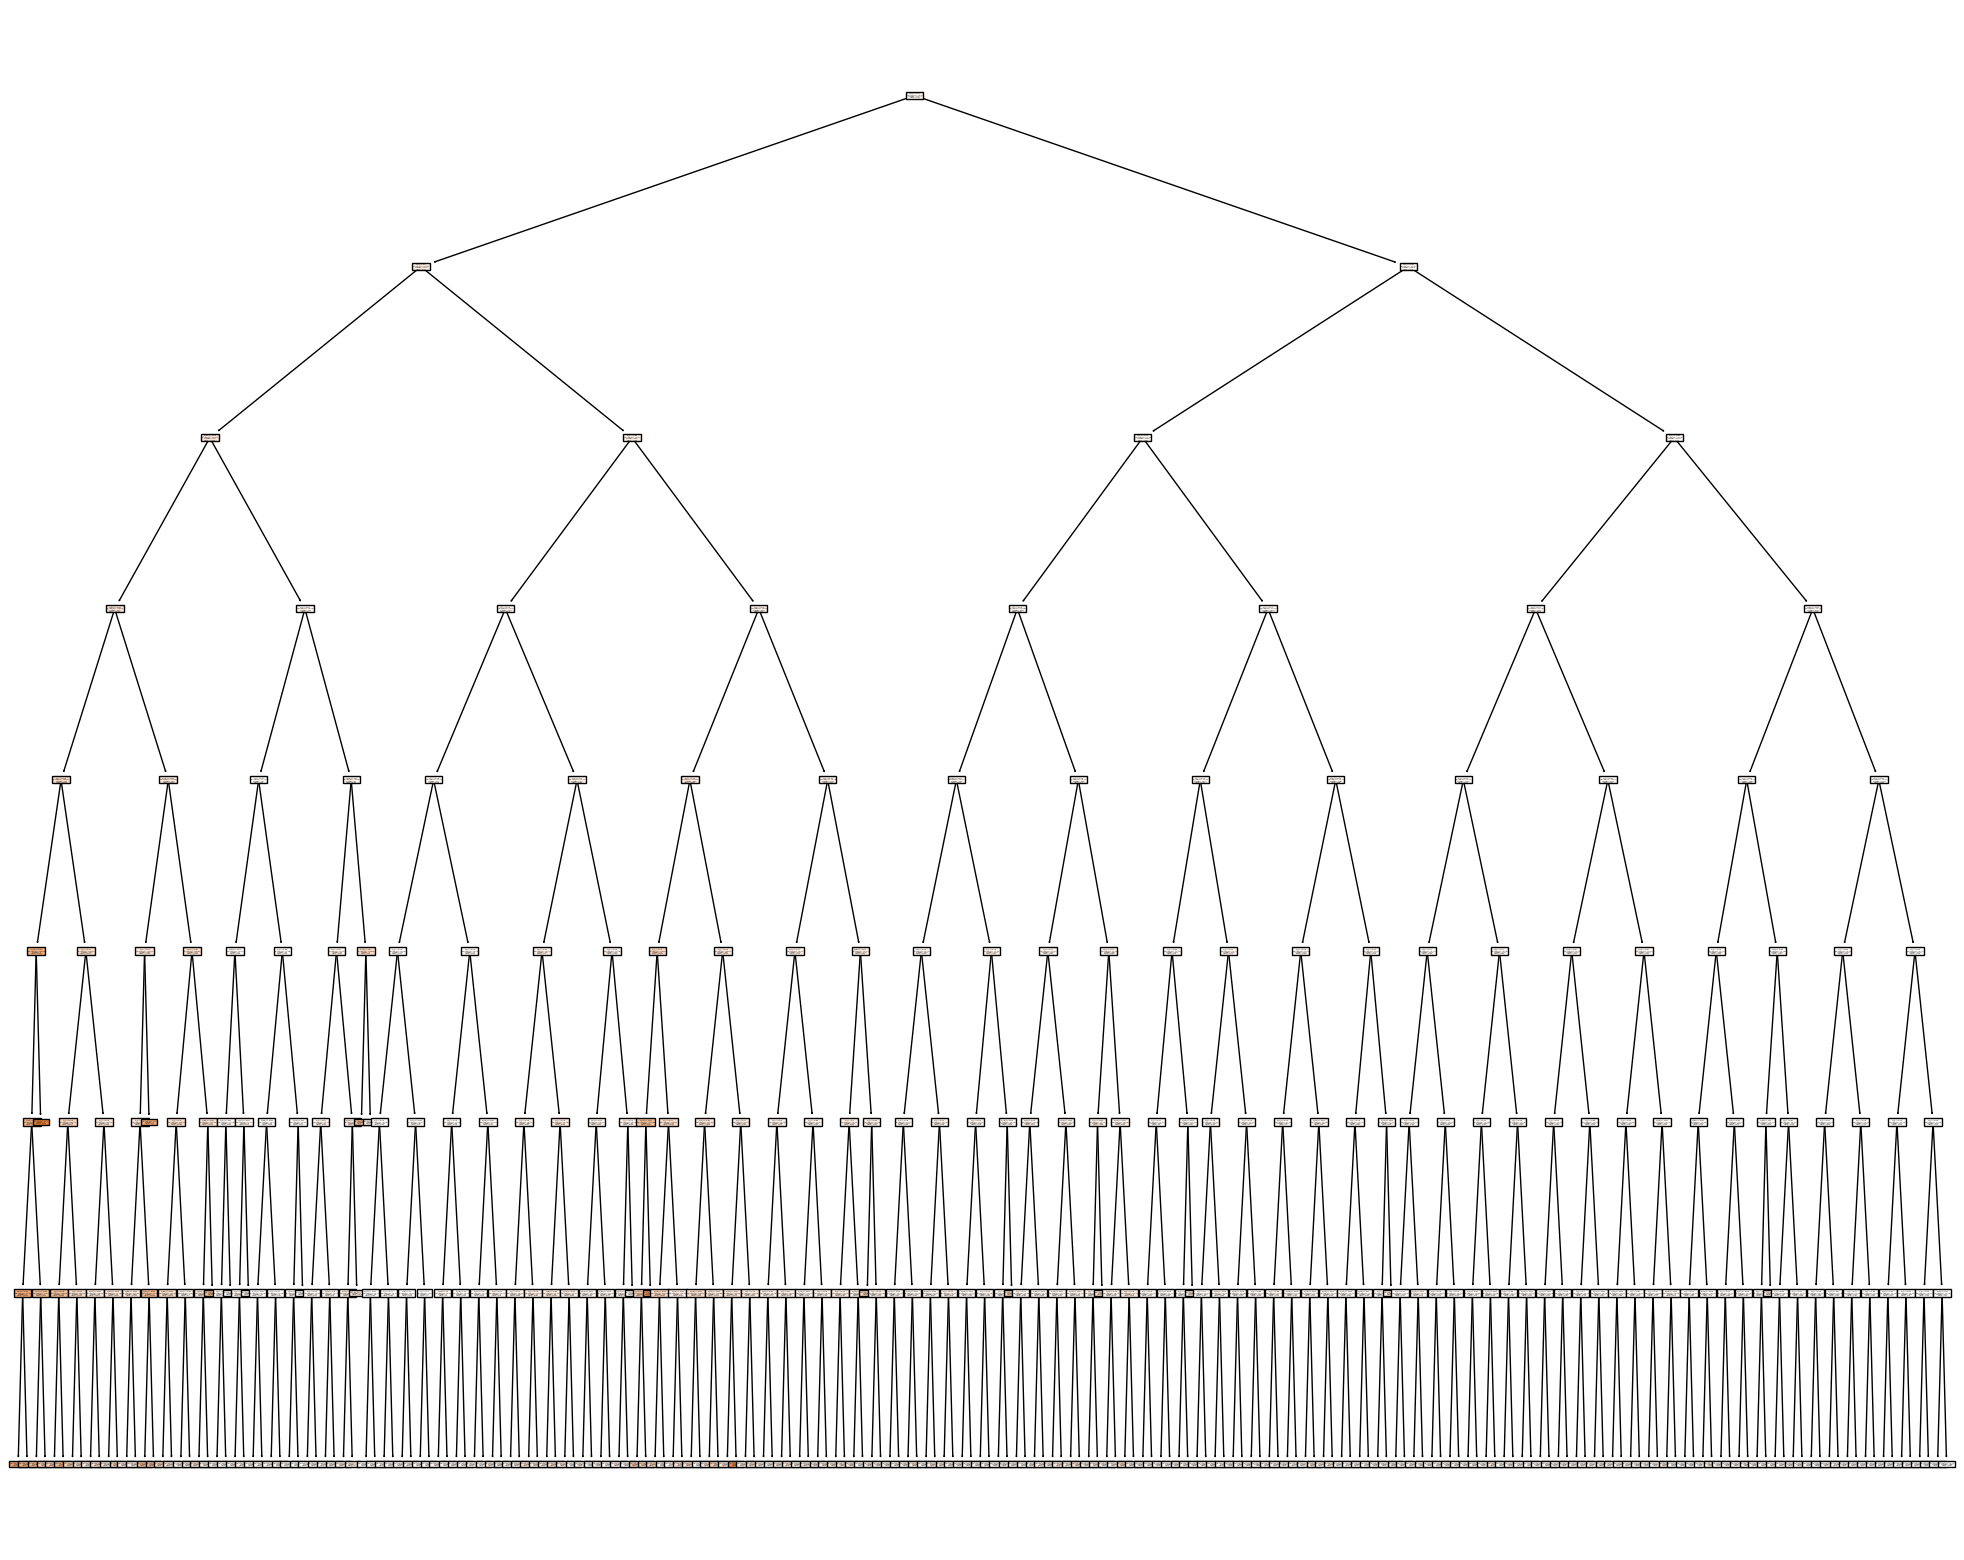

In [17]:
fig = plt.figure(figsize=(25, 20))
tree.plot_tree(regTree, filled=True)
plt.show()
fig.savefig("regression_tree.jpeg")

As observed, our regression model is way too complex to discern any useful information from the previous image. In the following cell, we will export and display the text representation of the model

In [16]:
text_representation = tree.export_text(regTree)
print(text_representation)

|--- feature_12 <= 0.01
|   |--- feature_12 <= 0.00
|   |   |--- feature_453 <= 0.02
|   |   |   |--- feature_453 <= 0.01
|   |   |   |   |--- feature_8 <= 0.15
|   |   |   |   |   |--- feature_90 <= 0.00
|   |   |   |   |   |   |--- feature_515 <= 0.00
|   |   |   |   |   |   |   |--- feature_16 <= 0.00
|   |   |   |   |   |   |   |   |--- value: [43.06]
|   |   |   |   |   |   |   |--- feature_16 >  0.00
|   |   |   |   |   |   |   |   |--- value: [37.81]
|   |   |   |   |   |   |--- feature_515 >  0.00
|   |   |   |   |   |   |   |--- feature_473 <= 0.00
|   |   |   |   |   |   |   |   |--- value: [31.72]
|   |   |   |   |   |   |   |--- feature_473 >  0.00
|   |   |   |   |   |   |   |   |--- value: [22.00]
|   |   |   |   |   |--- feature_90 >  0.00
|   |   |   |   |   |   |--- value: [58.59]
|   |   |   |   |--- feature_8 >  0.15
|   |   |   |   |   |--- feature_8 <= 0.31
|   |   |   |   |   |   |--- feature_0 <= 0.00
|   |   |   |   |   |   |   |--- feature_1 <= 0.14
|   |   |  

Lets run inference using our model and evaluate its loss and accuracy using the R2 score metric

In [12]:
pred = regTree.predict(X_test)
mse = mean_squared_error(y_test, pred)
acc = r2_score(y_test, pred)

print('MSE score : {0:.3f}'.format(mse))
print('R2 Score : {0:.3f}'.format(acc))

MSE score : 1.636
R2 Score : 0.726
